# Quantum Computing Exam
Jose Javier Fernández González

In [115]:
# Import Libaries
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import time

## Problem 1: Searching
### Parts 1 and 2

In [116]:
# Helper Functions

def hadamard_transform(wire_list):
    """Apply the Hadamard transform on a given set of wires.
    Args:
        wire_list (list[int]): A list of wires on which the Hadamard transform will act.
    """
    for wire in wire_list:
        qml.Hadamard(wires=wire)
    pass

def oracle(combo, wires):
    """Implement an oracle using a multi-controlled X gate.
    Args:
        combo (list): A list of bits representing the secret combination.
        wires (list): A list of wires to apply the oracle.
    """
    qml.MultiControlledX(wires=wires, control_values=combo)
    pass

def diffusion(query_register, all_wires):
    """Implement the diffusion operator using the Hadamard transform and
    multi-controlled X."""
    hadamard_transform(query_register)
    qml.MultiControlledX(wires=all_wires, control_values=[0]*len(query_register))
    hadamard_transform(query_register)
    pass

def grover_iter(combo, num_steps):
    """Run Grover search for a given secret combination and a number of iterations.

    Args:
        combo (list[int]): The secret combination, represented as a list of bits.
        num_steps (int): The number of Grover iterations to perform.

    Returns:
        array[float]: Probability for observing different outcomes.
    """
    n_bits = len(combo)
    query_register = list(range(n_bits))
    aux = [n_bits]
    all_wires = query_register + aux
    
    dev = qml.device("default.qubit", wires=all_wires)
    
    @qml.qnode(dev)
    def inner_circuit():
        # PREPARE AUXILIARY AND QUERY REGISTER 
        qml.PauliX(aux)
        hadamard_transform(all_wires)

        # APPLY GROVER ITERATION
        for _ in range(num_steps):
            oracle(combo, all_wires)
            diffusion(query_register, all_wires)

        return qml.probs(wires=query_register)

    return inner_circuit()

def run_experiment(max_num_steps, combo):
    prob_list = []
    for num_steps in range(1,max_num_steps+1):
        result = grover_iter(combo, num_steps)
        index = np.ravel_multi_index(combo, [2] * len(combo))
        prob_list.append(result[index])
    return prob_list

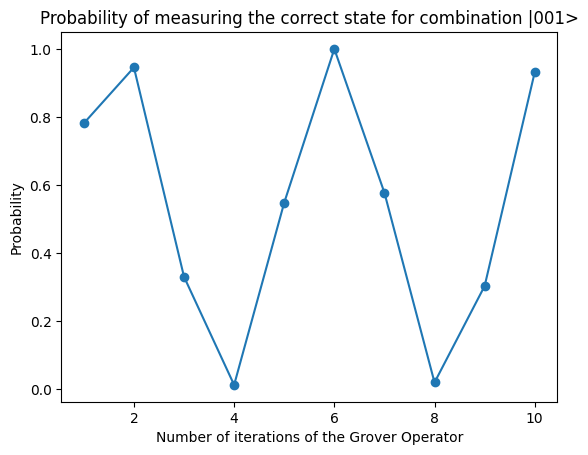

In [117]:
max_num_steps = 10
combo = (0,0,1)

plt.plot(range(1,max_num_steps+1), run_experiment(max_num_steps, combo), marker='o')
plt.xlabel("Number of iterations of the Grover Operator")
plt.ylabel("Probability")
plt.title(f"Probability of measuring the correct state for combination |001>")
plt.show()

### Part 3

In order to get the $|++-\rangle$ state after an arbitrary number of Grover Operator applications is tu just to apply a Pauli-Z to the third qubit, since the qubits state isn't altered, rather than its phase.

In [118]:

def grover_ppm(combo, num_steps):
    """Run Grover search for a given secret combination and a number of iterations.

    Args:
        combo (list[int]): The secret combination, represented as a list of bits.
        num_steps (int): The number of Grover iterations to perform.

    Returns:
        array[float]: Probability for observing different outcomes.
    """
    n_bits = len(combo)
    query_register = list(range(n_bits))
    aux = [n_bits]
    all_wires = query_register + aux
    
    dev = qml.device("default.qubit", wires=all_wires)
    
    @qml.qnode(dev)
    def inner_circuit():
        # PREPARE AUXILIARY AND QUERY REGISTER 
        qml.PauliX(aux)
        hadamard_transform(all_wires)

        # APPLY GROVER ITERATION
        for _ in range(num_steps):
            oracle(combo, all_wires)
            diffusion(query_register, all_wires)
        
        # APPLY PAULI Z TO LAST CONTROL QUBIT
        qml.PauliZ(query_register[-1])


### Part 4

In [119]:
def oracle_multi(combos, wires):
    """Implement multi-solution oracle using sequence of multi-controlled X gates.

    Args:
        combos (list[list[int]]): A list of solutions.
    """
    for combo in combos:
        qml.MultiControlledX(wires=wires, control_values=combo)
        pass

def grover_iter_mult(combo_list, num_steps):
    """Run Grover search for a given secret combination and a number of iterations.

    Args:
        combo_list (list[int]): A list of secret combinations, represented as a list of bits.
        num_steps (int): The number of Grover iterations to perform.

    Returns:
        array[float]: Probability for observing different outcomes.
    """
    n_bits = len(combo_list[0])
    query_register = list(range(n_bits))
    aux = [n_bits]
    all_wires = query_register + aux
    
    dev = qml.device("default.qubit", wires=all_wires)
    @qml.qnode(dev)
    def inner_circuit():
        # PREPARE AUXILIARY AND QUERY REGISTER 
        qml.PauliX(aux)
        hadamard_transform(all_wires)

        # APPLY GROVER ITERATION
        for _ in range(num_steps):
            oracle_multi(combo_list, all_wires)
            diffusion(query_register, all_wires)

        return qml.probs(wires=query_register)

    return inner_circuit()

In [120]:
def run_experiment(grover_variant, max_num_steps, combos_list):
    all_probs = []
    for num_steps in range(1, max_num_steps+1):
        result = grover_variant(combos_list, num_steps)
        indices = [np.ravel_multi_index(combo, [2] * len(combo)) for combo in combos_list]
        all_probs.append(result[indices])
    return np.array(all_probs)

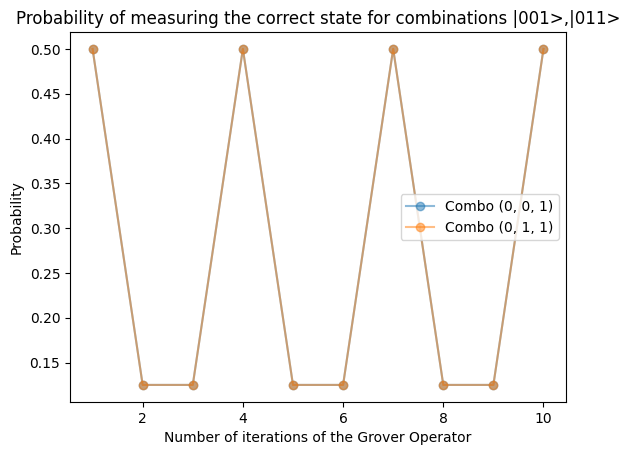

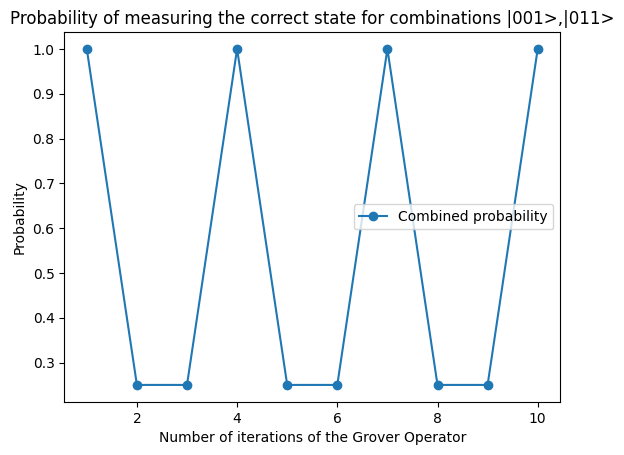

In [121]:
max_num_steps = 10
combos_list = [(0,0,1), (0,1,1)]
all_probs = run_experiment(grover_iter_mult, max_num_steps, combos_list)

# Separated by combination
for i, combo in enumerate(combos_list):
    plt.plot(range(1, max_num_steps+1), all_probs[:,i], marker='o', label=f"Combo {combo}", alpha=0.5)
plt.xlabel("Number of iterations of the Grover Operator")
plt.ylabel("Probability")
plt.title(f"Probability of measuring the correct state for combinations |001>,|011>")
plt.legend()
plt.show()


# Combined
plt.plot(range(1, max_num_steps+1), all_probs.sum(axis=1), marker='o', label=f"Combined probability")
plt.xlabel("Number of iterations of the Grover Operator")
plt.ylabel("Probability")
plt.title(f"Probability of measuring the correct state for combinations |001>,|011>")
plt.legend()
plt.show()

## Problem 2: Real world factoring
### Part 1

In [122]:
def native_multiplication(x,y):
    return x * y

def multi(x,y):
    z = 0
    while y>0:
        z += x
        y -= 1
    return z

def russian_peasant(x,y):
    z=0
    while y>0:
        if y%2 == 1:
            z += x
            x = x << 1
            y = y >> 1
    return z

In [123]:
# From the codebook, modified to fit multiplication fucntions

def nontrivial_square_root(m, multiplication_function):
    """Return the first nontrivial square root modulo m.

    Args:
        m (int): modulus for which want to find the nontrivial square root
        multiplication_function (func): function to use for multiplication method

    Returns:
        int: the first nontrivial square root of m
    """

    for x in range(2,m):
        if ( multiplication_function(x,x) -1)%m==0.:
            return x
    return None


def factorization(N, multiplication_function):
    """Return the factors of N.

    Args:
        N (int): number we want to factor.
        multiplication_function (func): function to use for multiplication method

    Returns:
        array[int]: [p,q] factors of N.
    """
    x = nontrivial_square_root(N, multiplication_function)

    if x:
        return np.gcd(x-1,N), np.gcd(x+1,N)
    else:
        return 0,0

In [124]:
# Helper functions
def gen_odd_nums(n_digits_max):
    num_array = np.array([])
    for n in range(1,n_digits_max):
        num_of_samples = 100 if n>2 else 10**n # starting from 3 digits, do only 100 nums per number of digits
        this_array = np.linspace(10**(n-1) + 1 , 10**(n), num=num_of_samples, dtype=int)
        # convert array into odd numbers
        this_array_odd = [num if num%2 else num+1 for num in this_array]
        num_array = np.concat([
            num_array,
            this_array_odd  
        ])
    return num_array.astype(int)

#### Native Python Multiplication

In [125]:
odd_numbers = gen_odd_nums(6)

num_digits = []
exec_time_vals = []

for N in odd_numbers:
    # Measure Execution Time
    t_i = time.perf_counter()
    factorization(N, native_multiplication)
    t_f =  time.perf_counter() - t_i
    
    # Append values
    exec_time_vals.append(t_f)
    num_digits.append(len(str(N)))


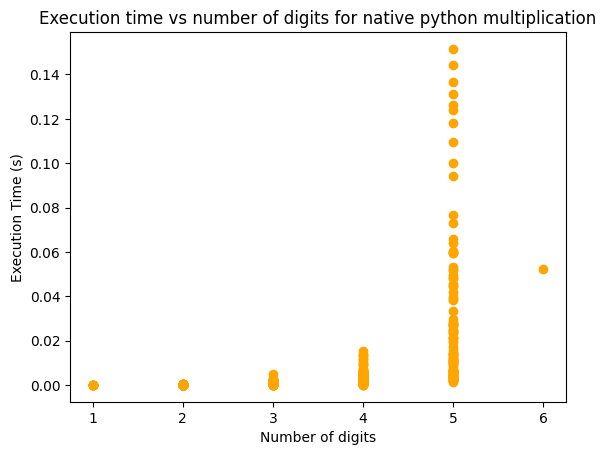

In [126]:
plt.scatter(num_digits, exec_time_vals, color="orange")
plt.title("Execution time vs number of digits for native python multiplication")
plt.xlabel("Number of digits")
plt.ylabel("Execution Time (s)")
plt.show()

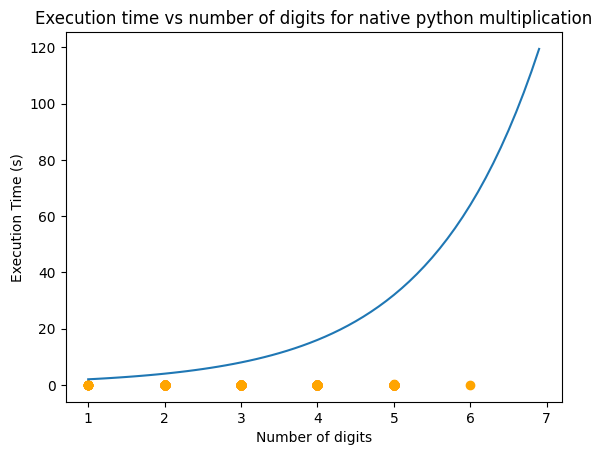

In [127]:
plt.scatter(num_digits, exec_time_vals, color="orange", label="Computed data")
plt.plot(np.arange(1,7,0.1), 2**(np.arange(1,7,0.1)), label="Curve Fit")
plt.title("Execution time vs number of digits for native python multiplication")
plt.xlabel("Number of digits")
plt.ylabel("Execution Time (s)")
plt.show()

#### Multi Function

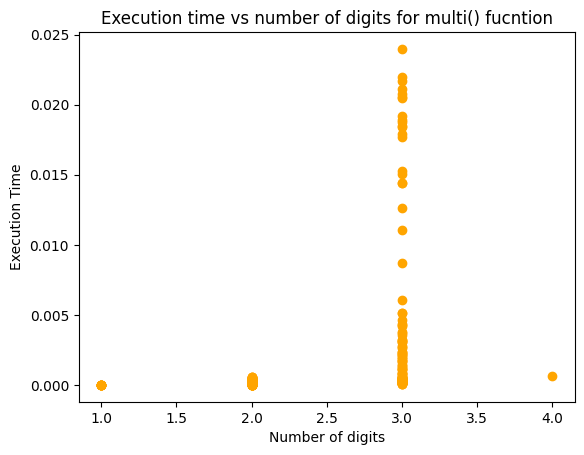

In [128]:
odd_numbers = gen_odd_nums(4)

num_digits = []
exec_time_vals = []

for N in odd_numbers:
    # Measure Execution Time
    t_i = time.perf_counter()
    factorization(N, multi)
    t_f =  time.perf_counter() - t_i
    
    # Append values
    exec_time_vals.append(t_f)
    num_digits.append(len(str(N)))

plt.scatter(num_digits, exec_time_vals, color="orange")
plt.title("Execution time vs number of digits for multi() fucntion")
plt.xlabel("Number of digits")
plt.ylabel("Execution Time")
plt.show()

#### Russian Peasant

In [130]:
odd_numbers = gen_odd_nums(3)

num_digits = []
exec_time_vals = []

for N in odd_numbers:
    # Measure Execution Time
    t_i = time.perf_counter()
    factorization(N, russian_peasant)
    t_f =  time.perf_counter() - t_i
    
    # Append values
    exec_time_vals.append(t_f)
    num_digits.append(len(str(N)))

plt.scatter(num_digits, exec_time_vals, color="orange")
plt.title("Execution time vs number of digits for russian_peasant() fucntion")
plt.xlabel("Number of digits")
plt.ylabel("Execution Time")
plt.show()

KeyboardInterrupt: 

### Part 2

A large number of quantum computers would help with distributed computation for factoring. If the number of qubits is smaller than required, the computation cannot represent the full problem instance, so Shor’s algorithm must either target a smaller integer or fail to provide a scalable speedup. If it is larger, you can encode larger integers (or add more error-correction/redundancy), which improves feasibility and potentially reduces runtime depth, though practical gains still depend on noise and connectivity.